### Controle Quântico Ótimo - Utilização do BFGS para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Heisenberg, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [2]:
def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t,psi, H):
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi)

# Runge-Kutta de quarta ordem
def rungeKutta(psi0, h, H, t = 2, t0 = 0):
    
    n = (int)((t-t0))
    S = np.zeros((2,int(t)), dtype=np.complex_)
    r = 0
    
    for i in range(0, n):
        
        S[0][r] = psi0[0][0]
        S[1][r] = psi0[1][0]
        
        k1 = dpsidt(t0, psi0, H)
        k2 = dpsidt(t0 + 0.5 * h, somar(psi0, np.dot((0.5*h), k1)), H)
        k3 = dpsidt(t0 + 0.5 * h, somar(psi0, np.dot((0.5*h), k2)), H)
        k4 = dpsidt(t0 + h, somar(psi0, np.dot(h, k3)), H)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        psi0 = somar(psi0,np.dot((h / 6.0),(C)))
    
        t0 = t0 + h
        
        r = r + 1
        
    return S

def fo(x, D, H, i, psi0):
    
    H1 = np.zeros((2,2), dtype=np.complex_)
    
    ## Tamanho do horizonte
    tam = 3
    
    M = np.zeros((2,1),dtype=np.complex_)
    M = [[psi0[0][0]], [psi0[1][0]]] 
    
    Result = np.zeros((2,1),dtype=np.complex_)
    
    Return = 0
    
    ## Função-Objetivo (Return) = ||somatorio (Matriz_Origem - Matriz_Destino)||^2
    for p in range(0+i, tam+i):
        H1 = [[0, x[p-i]], [x[p-i], 0]] # Controle
        Z = np.zeros((2,1),dtype=np.complex_)
        Z[0][0] = D[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*p/100)
        Z[1][0] = D[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*p/100)
        Return += np.linalg.norm(M-Z)**2
        Result = rungeKutta(M, h, somar(H,H1), t = (p-i)+2, t0 = 0)
        M = Result
    
    return Return

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [3]:
# Horizonte de análise
tam = 3
i = 0 # Iteração
h = 0.01 # Fator Runge-Kutta

# Proposta dos pontos
x = []
x.append(random.uniform(-5, 5))
for l in range(1, tam):
    x.append(x[0])

# Função de origem e destino
psi0 = [[complex(0.8,0.0)],[complex(0.6,0.0)]]
psid = [[complex(1/np.sqrt(2),0)],[complex(1/np.sqrt(2),0)]]


H = np.zeros((2,2), dtype=np.complex_) # Hamiltoniano
A = (1/2*np.pi)
B = (3/2*np.pi)
H = [[A, 0], [0, B]]

D = np.zeros((2,1), dtype=np.complex_) # Matriz destino
D[0][0] = psid[0][0]
D[1][0] = psid[1][0]

Resp = np.zeros((2, 2000), dtype=np.complex_)
Constantes = np.zeros((2, 2000), dtype=np.complex_)

while i < 2000:
    
    Resp[0][i] = psi0[0][0]
    Resp[1][i] = psi0[1][0]
    
    # Constantes da função de onda
    Constantes[0][i] = psi0[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100)
    Constantes[1][i] = psi0[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*i/100)
    
    resultado = optimize.minimize(fo, x, args=(D, H, i, psi0), method='BFGS')
    
    x = []
    x.append(resultado.x[0])
    for l in range(1, tam):
        x.append(x[0])
    
    ## Hamiltoniano corntrolado
    u = np.zeros((2,1), dtype=np.complex_)
    u = [[0, resultado.x[0]],[resultado.x[0], 0]]
    H = somar(H, u)
    
    ## Adaptação da onda ao controle
    psi_t = np.zeros((2,2), dtype=np.complex_)
    psi_t = rungeKutta(psi0, h, H, t = 2, t0 = 0)
    
    psi0[0][0] = psi_t[0][1]
    psi0[1][0] = psi_t[1][1]
    
    H = [[A, 0], [0, B]]
    
    i = i + 1

## Gráficos - Avaliação da defasagem

Conforme o livro, introdução à computação quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na parte real quanto imaginária, além de realizar a diferença entre essas partes.

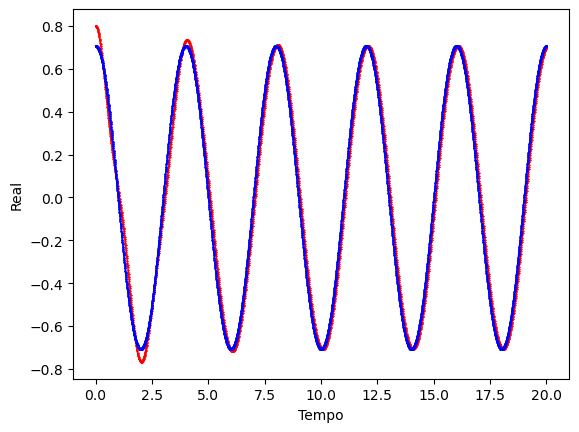

In [4]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

RealO = [ele.real for ele in Resp[0]] 
ImagO = [ele.imag for ele in Resp[0]] 

sup = []
for i in range(0, 2000):
    sup.append(1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
RealS = [ele.real for ele in sup]
ImagS = [ele.imag for ele in sup]

sub = []
for i in range(0, 2000):
    sub.append(abs(Resp[0][i] - sup[i]))

# Plotagem
plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.plot(ts, RealO, color='r', marker='*', linewidth=1, markersize=1)
plt.plot(ts, RealS, color='b', marker='o',  linewidth=1, markersize=1)
plt.savefig('rk_otimo1.png', format='png')
plt.show()

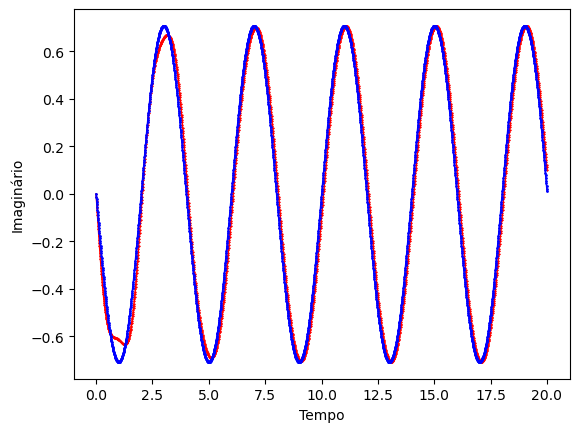

In [5]:
plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.plot(ts, ImagO, color='r', marker='*', linewidth=1, markersize=1)
plt.plot(ts, ImagS, color='b', marker='o',  linewidth=1, markersize=1)
plt.savefig('rk_otimo2.png', format='png')
plt.show()

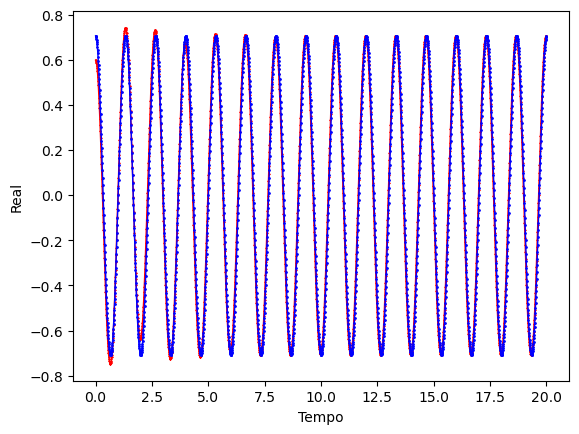

In [6]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

RealO = [ele.real for ele in Resp[1]] 
ImagO = [ele.imag for ele in Resp[1]] 

sup = []
for i in range(0, 2000):
    sup.append(1/np.sqrt(2)*np.exp(-3*complex(0,1)*(1/2*np.pi)*i/100))
RealS = [ele.real for ele in sup]
ImagS = [ele.imag for ele in sup]

subr = []
for i in range(0, 2000):
    subr.append(abs(Resp[1][i] - sup[i]))

# Plotagem
plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.plot(ts, RealO, color='r', marker='*', linewidth=1, markersize=1)
plt.plot(ts, RealS, color='b', marker='o',  linewidth=1, markersize=1)
plt.savefig('rk_otimo3.png', format='png')
plt.show()

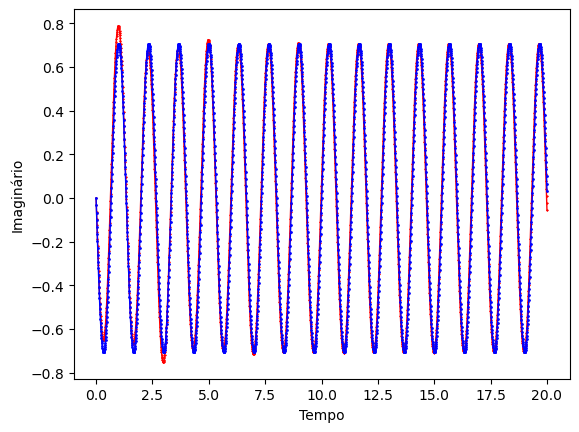

In [7]:
plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.plot(ts, ImagO, color='r', marker='*', linewidth=1, markersize=1)
plt.plot(ts, ImagS, color='b', marker='o',  linewidth=1, markersize=1)
plt.savefig('rk_otimo4.png', format='png')
plt.show()

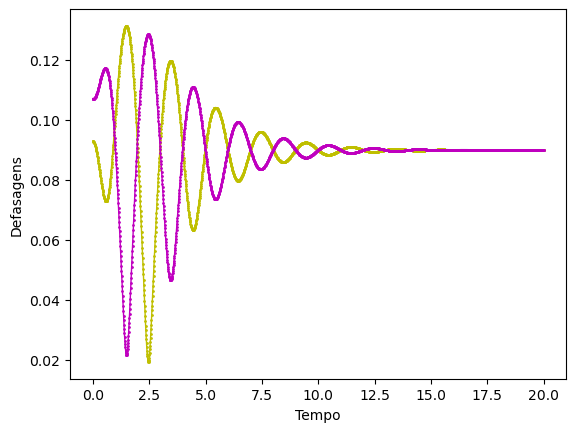

In [8]:
plt.ylabel('Defasagens') 
plt.xlabel('Tempo') 
plt.plot(ts, sub, color='y', marker='o',  linewidth=1, markersize=1)
plt.plot(ts, subr, color='m', marker='o',  linewidth=1, markersize=1)
plt.savefig('phases.png', format='png')
plt.show()

#### Valor da defasagem

In [9]:
print(subr[999])

0.09002597140795601


## Gráficos - Avaliação das constantes da função de onda

Outra interpretação pertinente é a obtenção das constantes de onda, pois o objetivo inicial da pesquisa é sair de uma constante e chegar em um estado de forma que estas estajam em total equilíbrio. Para realizar a plotagem com os diversos números complexos se faz o uso do número absoluto que para o estudo do conjunto complexo representa o seu tamanho, dessa forma, é possível indentificar se o estado inicial alcançou o final desejado.

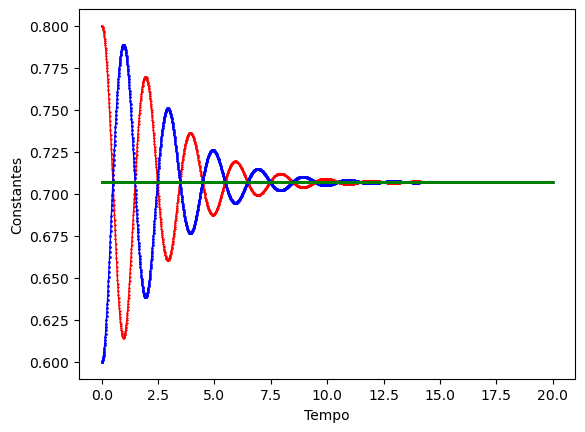

In [10]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(Constantes[0]), color='r', marker='*', linewidth=1, markersize=1)
plt.plot(ts, abs(Constantes[1]), color='b', marker='o',  linewidth=1, markersize=1)
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1)
plt.savefig('const.png', format='png')
plt.show()

## Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x

Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:$$\int |\Psi(x,t)|^{2}dx = 1$$ Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados: $$0.80\psi_0(x,t)+0.60\psi_1(x,t)$$ de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.

Se torna claro que a probabilidade total deve ser 1 e definindo o produto interno como $\int |\Psi(x,t)|^{2}dx = <\Psi | \Psi> = 1 = \sum_n |c_n|²$ podemos verificar se o ajuste da pesquisa está correto avaliando as constantes que são alteradas conforme o tempo de acordo com o gráfico apresentado acima.

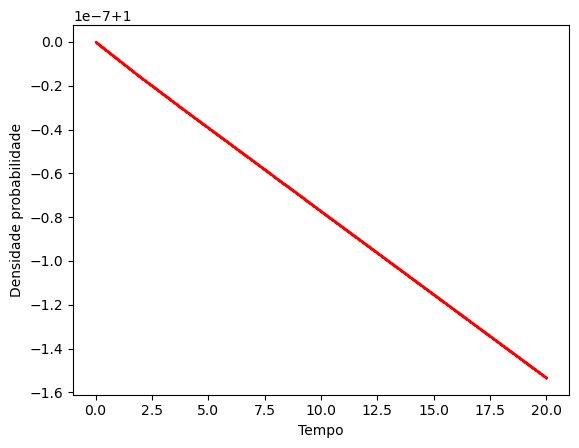

In [17]:
# Plotagem

dp = []
for i in range(0, 2000):
    dp.append((abs(Constantes[0][i])**2+abs(Constantes[1][i])**2))
    
plt.ylabel('Densidade probabilidade') 
plt.xlabel('Tempo') 
plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1)
plt.savefig('dp.png', format='png')
plt.show()